<a href="https://colab.research.google.com/github/hardiksahi/MachineLearning/blob/handle_high_cardinality_categorical/2_Weight_of_Evidence_High_Cardinality_Catgorical_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook explains Weight of Evidence encoding that is used to handle high cardinality (>100 levels) ordinal variables and / or bin numeric variables

**What is WOE encoding?**
WoE explains the predictive power of an independent variable in relation to dependent variable. It is described as:

$$WOE_{i} = ln(\frac{P(X=X_{i}|Y=1)}{P(X=X_{i}|Y=0)})$$

$$Numerator = \frac{N_{X=X_{i}, Y=1} + regularization }{N_{Y=1} + 2*regularization}$$
$$Denominator = \frac{N_{X=X_{i}, Y=0}+ regularization }{N_{Y=0} + 2*regularization}$$
$X_{i}$ is $i^{th}$ unique category of independent variable X and Y is dependent binary output variable with values 0 indicating non-event and 1 indicating event.

If WOE = 0 => Random outcome for the group

If WOE>0 => Numerator > Denominator => The given category provides greater evidence for outcome=1

If WOE<0 => Numerator < Denominator => The given category provides less evidence for outcome = 1

**regularization** is added to prevent division by 0

Note: WoE is useful in following cases:


*   **Nominal Categorical variable**:
      1.   Calculate WoE value for each category.
      2. Combine those categories together that have similar WoE value.
      3.   Use WOE values rather than raw categories in your model

*   **Numeric variable**:
      1. Create bins/ categories on continuous independent variable.
      2. Calculate WoE value for each category.
      3. Combine those categories together that have similar WoE value.
      4. Use WoE values instead of raw numeric values.

For both cases, categories/ bins which have similar dependent variable distribution in terms of events and non events are assigned similar values.






**Relevant links:**


1.   https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html
2.   https://www.kaggle.com/code/davidbnn92/weight-of-evidence-encoding/notebook#Using-stratified-WOE-encoding-for-final-output



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np
import pandas as pd

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, auc

In [5]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
! pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 9.3 MB/s eta 0:00:00


In [8]:
from category_encoders import WOEEncoder

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Github/titanic.csv")

## Step 1: Define output column

In [11]:
output_column = 'survived'

## Step 2: Split data into train and test set

In [12]:
X = df.copy()
y = df[output_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (1047, 14)
Shape of X_test: (262, 14)


In [17]:
stats = X['survived'].groupby(X['embarked']).agg(['sum', 'count'])

In [19]:
stats['sum']/X['survived'].sum()

embarked
C    0.300
Q    0.088
S    0.608
Name: sum, dtype: float64

In [ ]:
(stats['count']-stats['sum'])/X['survived'].sum()

In [18]:
stats

,sum,count
embarked,,
C,150,270
Q,44,123
S,304,914


In [21]:
X[X.embarked == 'C']['survived'].value_counts()

1    150
0    120
Name: survived, dtype: int64

In [22]:
X['survived'].count()

1309

## Step 3: Decide columns to WoE encode

In [13]:
woe_columns = ["home.dest", "cabin", "embarked"]

## Step 4: Use WoE to encode columns mentioned in woe_columns. WoEEncoder implementation handles overfitting. We will ensure that there is no data leakage by K fold CV


In [39]:
def perform_woe_encoding(train_df, target_col, test_df, columns_to_encode, encode_data_type ='train', handle_data_leakage='k_fold', folds=5, param_dict={'randomized':True, 'sigma':0.05, 'regularization':1.0}):
  assert train_df is not None and len(train_df)>0, 'Please pass train_data'
  assert target_col is not None, 'Please pass target_col'
  assert target_col in train_df.columns, f'Please ensure that {target_col} is a part of train_df'
  assert all([col in train_df.columns for col in columns_to_encode]), f'Please ensure columns: {columns_to_encode} are present in train_df'
  assert encode_data_type in ['train', 'test'], f'encode_data_type: {encode_data_type} not supported'

  if encode_data_type == 'train':
    ## perform K fold CV to encode training data with TE
    if handle_data_leakage == 'k_fold' and folds>1:
      train_labels_data = train_df[target_col]
      skf = StratifiedKFold(n_splits=folds, random_state=42, shuffle=True)
      encode_train_df_list = []

      for i, (train_index, val_index) in enumerate(skf.split(train_df, train_labels_data)):
        print(f'[START] Encoding fold number: {i}')
        if param_dict is not None:
          #handle_missing='value': Tells encoder to replace NA in column with global mean
          #handle_unknown='value': Tells encoder to replace unknown/ unseen category during fitting with global mean
          enc = WOEEncoder(cols=columns_to_encode, handle_missing='value', handle_unknown='value', return_df=True, **param_dict)
        else:
          ## smoothing: parameter 𝑓 in definition of lambda => How smoothly do we transition between conditional and global mean
          ## min_samples_leaf: parameter k in definition of lambda => Half of number of samples for which we have complete faith in conditional probability.
          enc = WOEEncoder(cols=columns_to_encode, handle_missing='value', handle_unknown='value', return_df=True, randomized=True, sigma=0.05, regularization=1.0)

        ## Get data to be encoded with TE (kth fold)
        kth_fold_train_df = train_df.iloc[val_index]
        ## Get remaining k-1 folds that will be used to calculate mean values for categories
        remaining_folds_train_df = train_df.iloc[train_index]
        remaining_folds_labels_data = train_df[target_col].iloc[train_index]

        ## Fit TE on remaining_folds_train_df and remaining_folds_labels_data
        enc.fit(remaining_folds_train_df, remaining_folds_labels_data)

        ## Transform kth_fold_train_df
        kth_fold_encoded_train_df = enc.transform(kth_fold_train_df)

        ## Ensure that raw values/ categories in columns_to_encode are also returned
        print(f'Concatenate raw columns to woe encoded df')
        encoded_column_names = [f'{col}_woe_encoded' for col in columns_to_encode]
        kth_fold_encoded_train_df = kth_fold_encoded_train_df.rename(columns=dict(zip(columns_to_encode, encoded_column_names)))
        raw_columns_df = kth_fold_train_df[columns_to_encode]
        kth_fold_encoded_train_df = pd.concat([kth_fold_encoded_train_df, raw_columns_df], axis=1)

        ## Gaussian noise is added automatically when randomized = True

        encode_train_df_list.append(kth_fold_encoded_train_df)
        print(f'===[END] Encoding fold number: {i}===')

      ## Concatenate encode_train_df_list
      final_encoded_train_df = pd.concat(encode_train_df_list, axis=0)
      return final_encoded_train_df.reindex(train_df.index)

  elif encode_data_type == 'test':
    assert test_df is not None and len(test_df)>0, 'Please pass test_df'
    assert all([col in test_df.columns for col in columns_to_encode]), f'Please ensure columns: {columns_to_encode} are present in test_df'

    print(f'[START] Encoding Test data')
    if param_dict is not None:
      #handle_missing='value': Tells encoder to replace NA in column with global mean
      #handle_unknown='value': Tells encoder to replace unknown/ unseen category during fitting with global mean
      enc = WOEEncoder(cols=columns_to_encode, handle_missing='value', handle_unknown='value', return_df=True, **param_dict)
    else:
      ## smoothing: parameter 𝑓 in definition of lambda => How smoothly do we transition between conditional and global mean
      ## min_samples_leaf: parameter k in definition of lambda => Half of number of samples for which we have complete faith in conditional probability.
      enc = WOEEncoder(cols=columns_to_encode, handle_missing='value', handle_unknown='value', return_df=True, randomized=True, sigma=0.05, regularization=1.0)

    ## Fit train_df on enc
    train_label_data = train_df[target_col]
    enc.fit(train_df, train_label_data)

    ## Tranform test_df
    encoded_test_df = enc.transform(test_df)

    ## Update the column names in test_encoded_train_df
    encoded_column_names = [f'{col}_woe_encoded' for col in columns_to_encode]
    encoded_test_df = encoded_test_df.rename(columns=dict(zip(columns_to_encode, encoded_column_names)))

    ## Ensure that raw columns are also returned
    print(f'Concatenate raw columns to target encoded df')
    raw_columns_df = test_df[columns_to_encode]
    encoded_test_df = pd.concat([encoded_test_df, raw_columns_df], axis=1)

    print(f'[END] Encoding Test data')

    return encoded_test_df.reindex(test_df.index)


In [40]:
woe_X_train_df = perform_woe_encoding(X_train, output_column, X_test, woe_columns, encode_data_type ='train', handle_data_leakage='k_fold', folds=5, param_dict={'randomized':True, 'sigma':0.05, 'regularization':1.0})
print(f'Shape of woe_X_train_df: {woe_X_train_df.shape}')

[START] Encoding fold number: 0
Concatenate raw columns to woe encoded df
===[END] Encoding fold number: 0===
[START] Encoding fold number: 1
Concatenate raw columns to woe encoded df
===[END] Encoding fold number: 1===
[START] Encoding fold number: 2
Concatenate raw columns to woe encoded df
===[END] Encoding fold number: 2===
[START] Encoding fold number: 3
Concatenate raw columns to woe encoded df
===[END] Encoding fold number: 3===
[START] Encoding fold number: 4
Concatenate raw columns to woe encoded df
===[END] Encoding fold number: 4===
Shape of woe_X_train_df: (1047, 17)


In [41]:
woe_X_test_df = perform_woe_encoding(X_train, output_column, X_test, woe_columns, encode_data_type ='test', param_dict={'randomized':True, 'sigma':0.05, 'regularization':1.0})
print(f'Shape of woe_X_test_df: {woe_X_test_df.shape}')

[START] Encoding Test data
Concatenate raw columns to target encoded df
[END] Encoding Test data
Shape of woe_X_test_df: (262, 17)


## Step 5: Encode remaining columns using sklearn transformer

In [42]:
ordinal_categorical_columns = ['pclass']
one_hot_categorical_column = ["sex"]
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'cabin_woe_encoded', 'embarked_woe_encoded', 'home.dest_woe_encoded']

In [43]:
mixed_preprocessor = ColumnTransformer([("numerical", "passthrough", numerical_columns), ("ordinal_encoding", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ordinal_categorical_columns), ("one_hot_encoding", OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False), one_hot_categorical_column)], verbose_feature_names_out=False)
mixed_preprocessor.set_output(transform="pandas")

ColumnTransformer(transformers=[('numerical', 'passthrough',
                                 ['age', 'sibsp', 'parch', 'fare',
                                  'cabin_woe_encoded', 'embarked_woe_encoded',
                                  'home.dest_woe_encoded']),
                                ('ordinal_encoding',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['pclass']),
                                ('one_hot_encoding',
                                 OneHotEncoder(handle_unknown='ignore',
                                               max_categories=20,
                                               sparse_output=False),
                                 ['sex'])],
                  verbose_feature_names_out=False)

In [44]:
final_encoded_X_train_df = mixed_preprocessor.fit_transform(woe_X_train_df)
final_encoded_X_test_df = mixed_preprocessor.transform(woe_X_test_df)

## Step 6: Train HistGradientBoostingClassifier

In [45]:
clf = HistGradientBoostingClassifier(verbose=5)

In [ ]:
clf.fit(final_encoded_X_train_df, woe_X_train_df[output_column])

In [48]:
precision_te, recall_te, thresholds_te = precision_recall_curve(woe_X_test_df[output_column], clf.predict_proba(final_encoded_X_test_df)[:,1])
area_te = auc(recall_te, precision_te)
print(f'area_te: {area_te}')

area_te: 0.8270117114752922


## Step 7: Perform K Fold CV

In [51]:
def perform_cv(df, output_column, folds = 5):
  skf = StratifiedKFold(n_splits=folds, random_state=42, shuffle=True)
  recall_list = []
  precision_list = []
  auc_pr_list = []
  for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"Start evaluating for fold: {i}")
    ## Perform TE on te_columns
    train_df = df.iloc[train_index]
    target_encoded_train_df = perform_woe_encoding(train_df, output_column, None, woe_columns, encode_data_type ='train', handle_data_leakage='k_fold', folds=folds, param_dict={'randomized':True, 'sigma':0.05, 'regularization':1.0})

    ## Perform remaining columns encoding
    mixed_preprocessor = ColumnTransformer([("numerical", "passthrough", numerical_columns), ("ordinal_encoding", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ordinal_categorical_columns), ("one_hot_encoding", OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False), one_hot_categorical_column)], verbose_feature_names_out=False)
    mixed_preprocessor.set_output(transform="pandas")
    all_encoded_train_df = mixed_preprocessor.fit_transform(target_encoded_train_df)

    ## Train classifier
    clf = HistGradientBoostingClassifier()
    clf.fit(all_encoded_train_df, train_df[output_column])

    ## Predict on val_df
    val_df = df.loc[val_index]
    target_encoded_val_df = perform_woe_encoding(train_df, output_column, val_df, woe_columns, encode_data_type ='test', param_dict={'randomized':True, 'sigma':0.05, 'regularization':1.0})
    all_encoded_val_df = mixed_preprocessor.transform(target_encoded_val_df)

    ## Predict on all_encoded_val_df
    pred_proba = clf.predict_proba(all_encoded_val_df)

    precision, recall, _ = precision_recall_curve(val_df[output_column], pred_proba[:,1])
    precision_list.append(precision)
    recall_list.append(recall)

    pr_auc = auc(recall, precision)
    auc_pr_list.append(pr_auc)
    # print(f'pr_auc: {pr_auc}')

    print(f"End evaluating for fold: {i}")

  return recall_list, precision_list, auc_pr_list


In [ ]:
recall_list, precision_list, auc_pr_list = perform_cv(X, output_column, folds = 5)

## Plot PR graph for all folds

In [57]:
max_len = max(len(precision) for precision in precision_list)
precisions_arr = np.full((len(precision_list), max_len), np.nan)
recalls_arr = np.full((len(recall_list), max_len), np.nan)
for i in range(len(precision_list)):
    precisions_arr[i, :len(precision_list[i])] = precision_list[i]
    recalls_arr[i, :len(recall_list[i])] = recall_list[i]

mean_precision = np.nanmean(precisions_arr, axis=0)
mean_recall = np.nanmean(recalls_arr, axis=0)
sort_inds = np.argsort(mean_recall)
mean_precision = mean_precision[sort_inds]
mean_recall = mean_recall[sort_inds]
mean_auc_pr = auc(mean_recall, mean_precision)

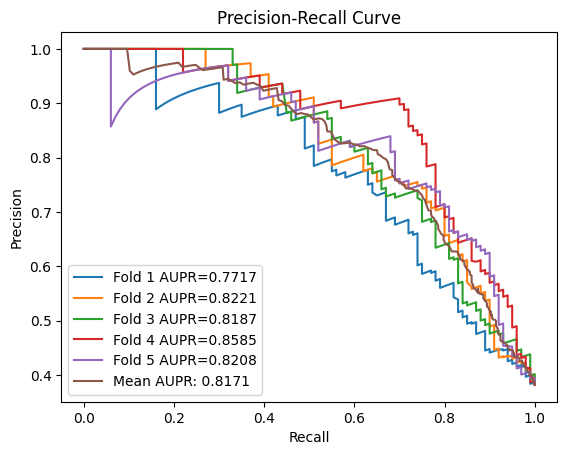

In [58]:
for i in range(len(precision_list)):
    plt.plot(recall_list[i], precision_list[i], label='Fold %d AUPR=%.4f' % (i+1, auc_pr_list[i]))
plt.plot(mean_recall, mean_precision, label='Mean AUPR: {:.4f}'.format(mean_auc_pr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()